In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.modeling import models, fitting
from __future__ import print_function
import seaborn
seaborn.set(font_scale=1.5)
datDIR = '../data/post_stamp_profiles/'
data = np.array([np.loadtxt(datDIR+'candy_'+str(i)+'_prof_i.dat', usecols=(0,1)) for i in range(1,7)])
numgals = data.shape[0]

### UDG Candidates
Postage-stamp images of 6 UDG candidates:

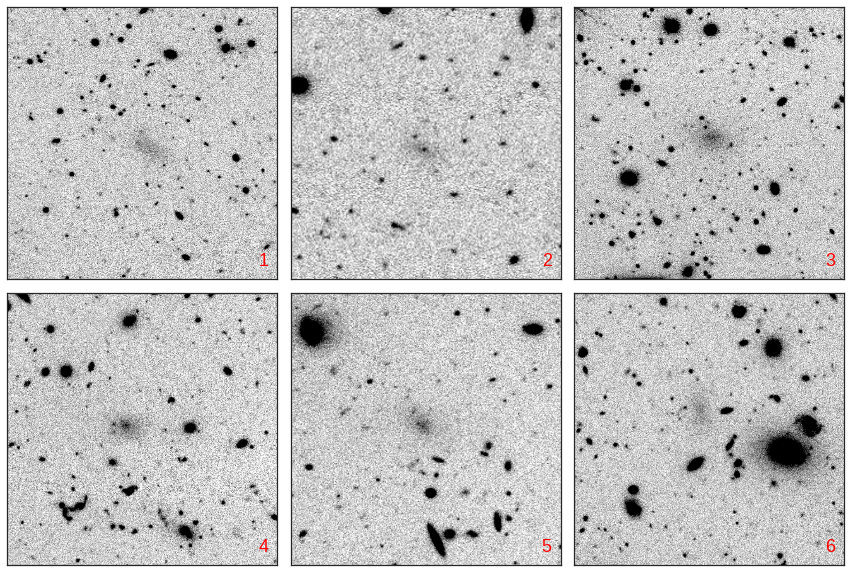

In [2]:
seaborn.set_style('white')
files = [datDIR+f for f in os.listdir(datDIR) if f[-4:]=='fits']
f0, a0 = plt.subplots(2,3, figsize=(15,10))
f0.subplots_adjust(wspace=0.05, hspace=0.05)
for i, f, a in zip(range(1,numgals+1), files, a0.flatten()):
    hdulist = fits.open(f)
    im = hdulist[1].data
    a.imshow(im, cmap='gray_r', vmin=-0.08, vmax=0.3, origin='lower', aspect='auto')
    a.text(0.93, 0.05, str(i), color='r', transform=a.transAxes)
    plt.setp(a.get_xticklabels(), visible=False)
    plt.setp(a.get_yticklabels(), visible=False)

## Surface brightness profiles
I made _very_ rough measurements of the SB profiles using DS9:

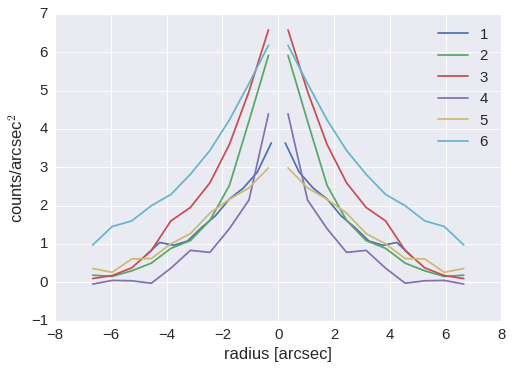

In [3]:
seaborn.set_style('darkgrid')
palette = seaborn.color_palette()
f1, a1 = plt.subplots()
for i in range(numgals):
    a1.plot(data[i,:,0], data[i,:,1], c=palette[i], label=str(i+1))
    a1.plot(-data[i,:,0], data[i,:,1], c=palette[i])
a1.set_xlabel('radius [arcsec]')
a1.set_ylabel(r'counts/arcsec$^2$')
a1.legend(loc='upper right');

## Approximate as Gaussians
Here, I fit Gaussians to the profiles:

In [4]:
fits = []
init_params = [(6., 0., 1.5), (10., 0., 1.5), (6., 0., 1.5),
               (5., 0., 1.0), (2.8, 0.0, 4.0), (8., 0., .5)]
for i in range(numgals):
    _a, _m, _s = init_params[i]
    g_init = models.Gaussian1D(amplitude=_a, mean=_m, stddev=_s)
    fit_g = fitting.LevMarLSQFitter()
    x = np.concatenate([-data[i,:,0], data[i,:,0]])
    y = np.concatenate([data[i,:,1], data[i,:,1]])
    fits.append(fit_g(g_init, x, y))

Let's see how good (bad) the fits are.. actually not _that_ bad:

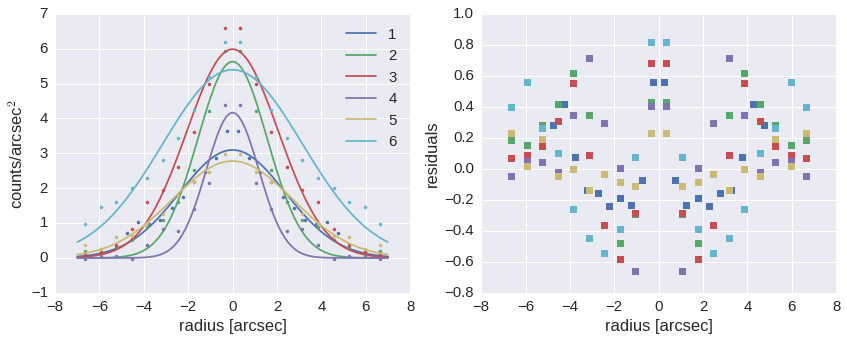

In [5]:
f2, a2 = plt.subplots(1,2,figsize=(14,5))
for i in range(numgals):
    x = np.concatenate([-data[i,:,0], data[i,:,0]])
    y = np.concatenate([data[i,:,1], data[i,:,1]])
    a2[0].plot(x, y, '.', c=palette[i])
    xfit = np.linspace(-7,7,101)
    a2[0].plot(xfit, fits[i](xfit), '-', c=palette[i], label=str(i+1))
    a2[1].plot(x, y - fits[i](x), 's', c=palette[i])
a2[0].legend(loc='upper right')
a2[0].set_xlabel('radius [arcsec]')
a2[0].set_ylabel(r'counts/arcsec$^2$')
a2[1].set_xlabel('radius [arcsec]')
a2[1].set_ylabel(r'residuals');

## Sizes
The implied FWHM values are

In [6]:
for i in range(numgals):
    print(i+1, 'fwhm =', round(2.355*fits[i].stddev.value, 2), 'arcsec')

1 fwhm = 5.59 arcsec
2 fwhm = 3.68 arcsec
3 fwhm = 4.86 arcsec
4 fwhm = 2.79 arcsec
5 fwhm = 6.36 arcsec
6 fwhm = 7.41 arcsec


### Note
The fwhm of candidate 6 seems a bit large. I think this may be due to light from bright point sources in the galaxy's outskirts.

## Surface Brightness
Assuming we get half the light within a circle of radius 0.5*FHWM, here's the SB values:

In [7]:
imag = [21.21, 21.10, 21.19, 22.35, 21.47, 20.6] # total i-band magnitudes from Andy 
for i in range(numgals):
    i_eff = imag[i] - 2.5*np.log10(0.5) # assume we get half the light
    r = 2.355*fits[i].stddev.value/2.0  # assume circle with r = 0.5*FWHM
    print(i+1, 'SB ~', round(i_eff + 2.5*np.log10(np.pi*r**2),2), 'mag/arcsec^2')

1 SB ~ 25.44 mag/arcsec^2
2 SB ~ 24.42 mag/arcsec^2
3 SB ~ 25.11 mag/arcsec^2
4 SB ~ 25.07 mag/arcsec^2
5 SB ~ 25.98 mag/arcsec^2
6 SB ~ 25.44 mag/arcsec^2


## A Summary of the GMOS-N B600 and R150 gratings: <br>


| Grating| Blaze [nm]| Resolution $\lambda/\delta \lambda$ |Dispersion [nm/pixel]| Simultaneous coverage [nm]|
|:--------:|:------------------:|:------------------------:|:-------------------:|:--------------------------:|
| B600     |     461            |       1688               |     0.045           |        276                |
| R150     |     717            |       631                |     0.174           |        1071                 |


## The grating efficiency:

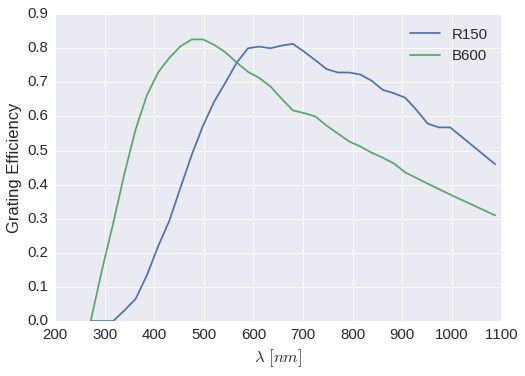

In [8]:
url = 'http://www.gemini.edu/sciops/instruments/gmos/gratings/gmos_n_B600_G5303.txt'
B600 = pd.read_csv(url, skiprows=13, delim_whitespace=True, names=['lambda', 'B600'])
url = 'http://www.gemini.edu/sciops/instruments/gmos/gratings/gmos_n_R150_G5306.txt'
R150 = pd.read_csv(url, skiprows=13, delim_whitespace=True, names=['lambda', 'R150'])
ax = B600.plot(x='lambda', y='B600', ax=R150.plot(x='lambda', y='R150'), xlim=[200,1100])
ax.set_xlabel('$\lambda\ [nm]$')
ax.set_ylabel('Grating Efficiency');

### Observational parameters for the redshift measurement of UDG DF 44 ([van Dokkum et al. 2016](http://adsabs.harvard.edu/abs/2015ApJ...804L..26V)) <br>
| Blaze [$\unicode{x212B}$]       | Resolution $\lambda/\delta \lambda$ |Slit Width [arcsec]| Integration Time [hr]| S/N [ $\unicode{x212B}^{-1}$ ]|
|:------------------:|:------------------------:|:-------------------:|:--------------------------:| :------:|
 |     4000            |       1800               |     1.5             |        1.5        |  $\sim$5 |
 
 |$m_V$|$m_g$ | r$_\mathrm{eff}$ [arcsec]| $\mu$($V$,r<3$^{\prime\prime}$) [mag/arcsec$^2$]|$\mu$($V$,r<20$^{\prime\prime}$) [mag/arcsec$^2$]| Sersic Index|
 |:-----:|:----:|:----: | :----------:| :-----------:|:--------: |
 |18.9| 19.4 |  8.9| 24.6 |28| 0.89 |

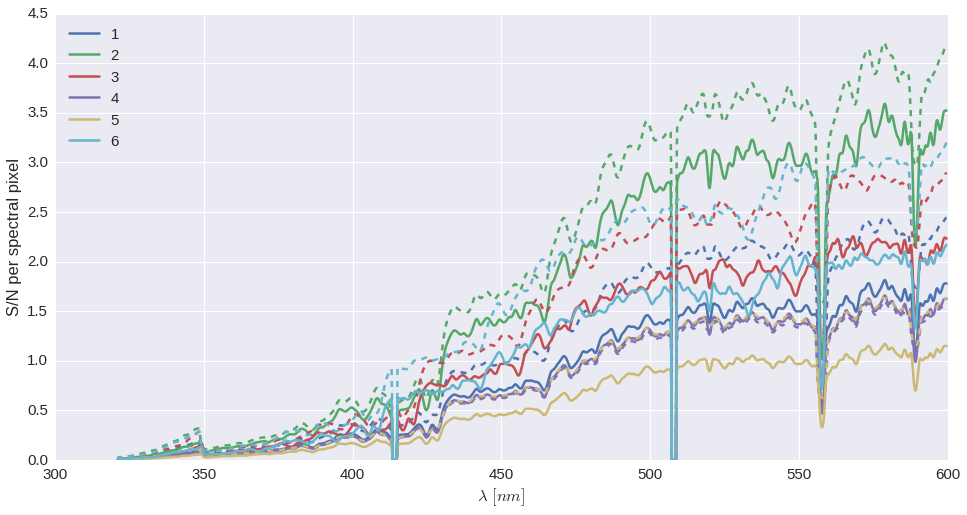

In [9]:
f3, a3 = plt.subplots(figsize=(16,8))
for i in range(numgals):
    itc_2 = np.loadtxt(datDIR+'itc/candy_'+str(i+1)+'_snr_itc_2slit_2hr.dat')
    itc_5 = np.loadtxt(datDIR+'itc/candy_'+str(i+1)+'_snr_itc_5slit_2hr.dat')
    a3.plot(itc_2[:,0], itc_2[:,1], c=palette[i], label=str(i+1), lw=2.5)
    a3.plot(itc_5[:,0], itc_5[:,1], c=palette[i], ls='--', lw=2.5)
a3.legend(loc=0)
a3.set_xlabel('$\lambda\ [nm]$')
a3.set_ylabel('S/N per spectral pixel');

### Figure Note: 
Solid lines correspond to a slit width of 2$^{\prime\prime}$, and dashed lines correspond to a slit width of 5$^{\prime\prime}$. All calculations assume a total integration time of 2 hrs. 